In [1]:
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt 
from plot_function import *
from itertools import cycle
from pathlib import Path
from datetime import date

In [2]:
connection = sqlite3.connect('./sample_database.db')
c = connection.cursor()

# Extract data from database

In [3]:
TC_fit = pd.read_sql_query("""SELECT * FROM tc_fit_results""", con=connection)
HB_fit = pd.read_sql_query("SELECT * FROM hb_fit_results", con=connection)
amp_sweeps = pd.read_sql_query("""SELECT * FROM amp_sweep_info""", con=connection)
solvents = pd.read_sql_query("SELECT * FROM solvent_infos", con=connection)
dilu = pd.read_sql_query("""SELECT sample_prep_info.*, 
                                   dilution_series.dilution_serie
                            FROM sample_prep_info
                            LEFT JOIN dilution_series USING (sample_ID)
                         """, con=connection)
frq_sweeps = pd.read_sql("select * from frq_sweep_info", con=connection)
flow_curves = pd.read_sql("select * from flow_curves", con=connection)

# Plot the concentration sweep

In [4]:
flow_curves = pd.merge(left=flow_curves, right=dilu, how='left', on=['sample_ID'])
flow_curves_concentration_sweep = flow_curves[flow_curves.dilution_serie == 'carbopol~974p~in~propylenglycol']

df20 = flow_curves_concentration_sweep[flow_curves_concentration_sweep.temperature == 20]
df20 = df20.sort_values('w_percent', ascending=False)

name,TC_eta_bg,TC_gammadot_crit,TC_ystress,AIC
key,,,,
1.3,0.307,0.000,0.001,460.270
1.5,0.397,0.000,0.002,539.734
1.7,0.449,0.000,0.003,187.440
1.75,0.466,0.000,0.005,-6.878
1.78,0.450,0.021,2.237,1.069
1.8,0.485,0.019,2.599,-45.003
1.85,0.478,0.068,5.071,-74.010
1.9,0.459,0.025,3.205,374.841
2.0,0.493,0.151,10.037,218.437


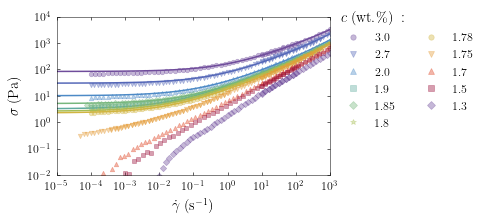

In [5]:
import rheofit
TC_model=rheofit.models.TC_model


fig, ax, color, marker = create_plot()
x = np.logspace(-5, 3, 30)
c_for_TC=[3.0,2.7,2.0,1.9,1.85,1.8, 1.78]

import pybroom
res_fit_dict={}
AIC_list=[]
for c, dfh in df20.groupby('w_percent', sort=False):
    col=next(color)
    ax.loglog(dfh.shear_rate, dfh.shear_stress, c=col, mfc=col, alpha=0.4, marker=next(marker), label=f'${c}$', linestyle='none')
    res_fit_dict[c]=TC_model.fit(dfh.shear_stress,x=dfh.shear_rate)
    AIC_list.append(res_fit_dict[c].aic)
    if c in c_for_TC:
        plt.plot(x, res_fit_dict[c].eval(x=x), color=col, marker='', ls='-', lw=1.5)
     

    
res_table=pybroom.tidy(res_fit_dict)
TC_fit_table=res_table.pivot(index='key',columns='name',values='value')
TC_fit_table['AIC']=AIC_list

ax.legend(title='$c~(\mathrm{wt.}\%)~:$', bbox_to_anchor=(1, 1.1), ncol=2)._legend_box.align='left'
ax.set(xlim=(1e-5, 1e3), ylim=(1e-2, 1e4))
ax.set(xlabel='$\dot{\gamma}~(\mathrm{s}^{-1})$', 
       ylabel='$\sigma~\mathrm{(Pa)}$', 
      xticks=[1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1000], 
      yticks=[0.01, 0.1, 1, 10, 100, 1000, 10000])
fig.savefig('./figures_marco/concentration_sweep.svg')
fig.savefig('./figures_marco/concentration_sweep.png', dpi=400, bbox_inches = 'tight')
TC_fit_table.round(3)



In [6]:
res_fit_dict_HB={}
AIC_list=[]
for c, dfh in df20.groupby('w_percent', sort=False):
    col=next(color)
    ax.loglog(dfh.shear_rate, dfh.shear_stress, c=col, mfc=col, alpha=0.4, marker=next(marker), label=f'${c}$', linestyle='none')
    res_fit_dict_HB[c]=rheofit.models.HB_model.fit(dfh.shear_stress,x=dfh.shear_rate)
    AIC_list.append(res_fit_dict_HB[c].aic)
res_table=pybroom.tidy(res_fit_dict_HB)
HB_fit_table=res_table.pivot(index='key',columns='name',values='value')
HB_fit_table['AIC']=AIC_list
HB_fit_table.round(3)

name,HB_K,HB_n,HB_ystress,AIC
key,,,,
1.3,2.088,0.770,0.048,496.820
1.5,4.229,0.725,0.856,587.324
1.7,4.742,0.727,1.887,316.831
1.75,8.935,0.671,2.010,250.423
1.78,10.734,0.635,4.644,196.189
1.8,13.429,0.623,5.309,148.454
1.85,14.301,0.616,7.669,159.230
1.9,12.754,0.643,7.643,373.871
2.0,17.429,0.622,15.349,253.925


# TC Parameters for concentration sweep

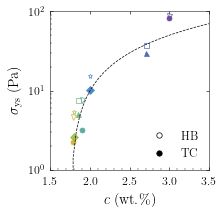

In [7]:
fig, ax, color, marker = create_plot(two_sided=True)

for conc in c_for_TC:
    c = next(color)
    ax.plot(conc, TC_fit_table['TC_ystress'][conc], c=c, mfc=c, marker=next(marker), ms=5, label='$\mathrm{TC}$')
    ax.plot(conc, HB_fit_table['HB_ystress'][conc], c=c, mfc='None', marker=next(marker), ms=5, label='$\mathrm{HB}$')
    
handles = [mpl.lines.Line2D([], [], c='k', label=r'$\mathrm{HB}$'),
           mpl.lines.Line2D([], [], c='k', mfc='k', label=r'$\mathrm{TC}$')]

ax.plot(np.linspace(1.5,3.5),40*(np.linspace(1.5,3.5)-1.75), linestyle='--', color='black', marker='')

ax.legend(handles=handles, loc='lower right')

ax.set(xlim=(1.5, 3.5), ylim=(1, 100), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\sigma_\mathrm{ys}~\mathrm{(Pa)}$'
      )

fig.savefig('./figures_marco/concentration_sweep_parameters/ys.svg')

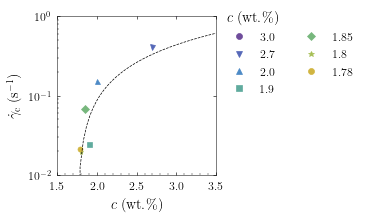

In [8]:
fig, ax, color, marker = create_plot(two_sided=True)

for conc in c_for_TC:
    c = next(color)
    ax.plot(conc, TC_fit_table['TC_gammadot_crit'][conc], c=c, mfc=c, marker=next(marker), ms=5, label=f'${conc}$')
    
ax.legend(title='$c~(\mathrm{wt.}\%)$', ncol=2, bbox_to_anchor=(1, 1.1))._legend_box.align='left'
    
ax.plot(np.linspace(1.5,3.5),0.35*(np.linspace(1.5,3.5)-1.75), linestyle='--', color='black', marker='')


ax.set(xlim=(1.5, 3.5), ylim=(1e-2, 1), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\dot{\gamma}_\mathrm{c}~\mathrm{(s^{-1})}$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/gammadotcrit.svg')

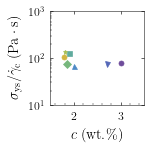

In [9]:
fig, ax, color, marker = create_plot(figsize=(2.5,2.5))

for conc in c_for_TC:
    c = next(color)
    ax.plot(conc, TC_fit_table.loc[conc, 'TC_ystress']/TC_fit_table.loc[conc, 'TC_gammadot_crit'], c=c, mfc=c, marker=next(marker), ms=5, label=f'${conc}$')
    
    
#ax.plot(np.linspace(1.5,3.5),0.35*(np.linspace(1.5,3.5)-1.75), linestyle='--', color='black', marker='')


ax.set(xlim=(1.5, 3.5), ylim=(10, 1000), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\sigma_\mathrm{ys} / \dot{\gamma}_\mathrm{c}~\mathrm{(Pa \cdot s)}$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/ys_gammadotcrit.svg')

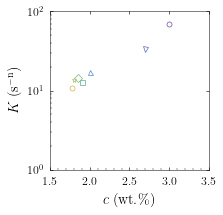

In [10]:
fig, ax, color, marker = create_plot(two_sided=True)

for conc in c_for_TC:
    c = next(color)
    ax.plot(conc, HB_fit_table['HB_K'][conc], c=c, mfc='none', marker=next(marker), ms=5)
    


ax.set(xlim=(1.5, 3.5), ylim=(1, 100), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$K~\mathrm{(s^{-n})}$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/k.svg')

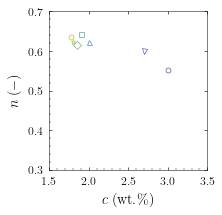

In [11]:
fig, ax, color, marker = create_plot(two_sided=True)

for conc in c_for_TC:
    c = next(color)
    ax.plot(conc, HB_fit_table['HB_n'][conc], c=c, mfc='none', marker=next(marker), ms=5)
    


ax.set(xlim=(1.5, 3.5), ylim=(0.3, 0.7), 
       yscale='linear',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$n~(-)$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/n.svg')

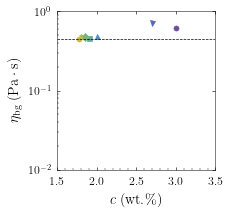

In [12]:
fig, ax, color, marker = create_plot(two_sided=True)

for conc in c_for_TC:
    c = next(color)
    ax.plot(conc, TC_fit_table['TC_eta_bg'][conc], c=c, mfc=c, marker=next(marker), ms=5)

ax.axhline(0.45, linestyle='--', color='black', marker='')

ax.set(xlim=(1.5, 3.5), ylim=(0.01, 1), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\eta_\mathrm{bg}~\mathrm{(Pa \cdot s)}$'
      )

fig.savefig('./figures_marco/concentration_sweep_parameters/viscinf.svg')

# Effect of temperature 

In [13]:
TC_fit = pd.read_sql_query("""SELECT * FROM tc_fit_results""", con=connection)
amp_sweeps = pd.read_sql_query("""SELECT * FROM amp_sweep_info""", con=connection)
solvents = pd.read_sql_query("SELECT * FROM solvent_infos", con=connection)
dilu = pd.read_sql_query("""SELECT sample_prep_info.*, 
                                   dilution_series.dilution_serie
                            FROM sample_prep_info
                            LEFT JOIN dilution_series USING (sample_ID)
                         """, con=connection)
frq_sweeps = pd.read_sql("select * from frq_sweep_info", con=connection)
flow_curves = pd.read_sql("select * from flow_curves", con=connection)
sample=pd.read_sql("select * from tc_fit_results", con=connection)

df = pd.merge(left=sample, right=amp_sweeps, on=['sample_ID', 'temperature'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
df = pd.merge(left=df, right=dilu, on=['sample_ID'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
df = pd.merge(left=df, right=solvents, on=['solvent', 'temperature'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')


marco_visc = pd.read_csv('visc_pg_from_Marco.txt', sep='\t')
marco_visc['round_temperature'] = round(marco_visc.Temperature)
marco_visc['roundtemperature'] = round(marco_visc.Temperature)

visc_round = marco_visc.groupby('round_temperature')['Viscosity'].mean()

PG = solvents.query("solvent == 'propylenglycol'")
PG = PG.sort_values('temperature')

visc_round

round_temperature
10.0    0.102050
11.0    0.098107
12.0    0.092068
13.0    0.086123
14.0    0.080511
15.0    0.075337
16.0    0.070478
17.0    0.066006
18.0    0.061838
19.0    0.058372
20.0    0.054799
21.0    0.051491
22.0    0.048458
23.0    0.045629
24.0    0.042894
25.0    0.040253
26.0    0.037959
27.0    0.035865
28.0    0.033923
29.0    0.032261
30.0    0.030566
31.0    0.028952
32.0    0.027531
33.0    0.026069
34.0    0.024876
35.0    0.023787
36.0    0.022553
37.0    0.021460
38.0    0.020486
39.0    0.019429
40.0    0.018617
41.0    0.017891
42.0    0.017030
43.0    0.016265
44.0    0.015637
45.0    0.015026
46.0    0.014478
47.0    0.013870
48.0    0.013247
49.0    0.012744
50.0    0.012257
51.0    0.011780
52.0    0.011349
53.0    0.010922
54.0    0.010609
55.0    0.010248
56.0    0.009831
57.0    0.009415
58.0    0.009045
59.0    0.008731
60.0    0.008467
Name: Viscosity, dtype: float64

10.0
0.10205033333333334
15.0
0.07533733333333333
20.0
0.05479937142857143
25.0
0.04025268333333334
30.0
0.0305657
35.0
0.023787283333333336
40.0
0.01861688
45.0
0.0150264
50.0
0.01225682857142857


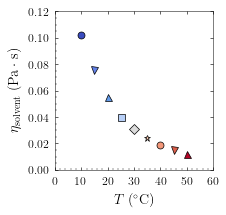

In [14]:
fig, ax, _, marker = create_plot(two_sided=True)
dict_colors = {10: '#3a4cbf', 15: '#6281e9', 20: '#629ae9',
               25: '#b7cff7', 30:'#dbdbdb', 35: '#f3c3ab', 
               40: '#f39779', 45: '#db5e4a', 50: '#b30426'
                }
for T in np.linspace(10, 50, 9):
    print(T)
    print(visc_round[T])
    ax.plot(T, visc_round[T], c='k', ls='--', mfc=dict_colors[T], marker=next(marker), ms=7)
ax.set(xlim=(0, 60), ylim=(0, 0.12), 
       xticks=[0, 10, 20, 30, 40, 50, 60],
       xlabel='$T~(^\circ \mathrm{C})$', ylabel='$\eta_\mathrm{solvent}~\mathrm{(Pa \cdot s)}$')
fig.savefig('solvent_visc.svg', bbox_inches = 'tight')

In [15]:
df_temp = flow_curves_concentration_sweep[flow_curves_concentration_sweep.w_percent == 1.9]

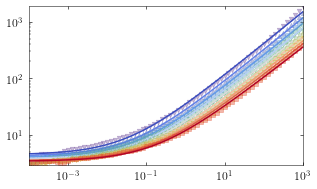

In [22]:
res_fit_dict_HB={}
AIC_list=[]
fig, ax, color, amerker = create_plot()
for c, dfh in df_temp.groupby('temperature', sort=False):
    col=next(color)
    ax.loglog(dfh.shear_rate, dfh.shear_stress, c=col, mfc=col, alpha=0.4, marker=next(marker), label=f'${c}$', linestyle='none')
    res_fit_dict_HB[c]=rheofit.models.HB_model.fit(dfh.shear_stress,x=dfh.shear_rate, weights=1/dfh.shear_stress)
    ax.plot(x, res_fit_dict_HB[c].eval(x=x), color=dict_colors[c], marker='', ls='-', lw=1.5)
    AIC_list.append(res_fit_dict_HB[c].aic)
res_table=pybroom.tidy(res_fit_dict_HB)
HB_fit_table=res_table.pivot(index='key',columns='name',values='value')
HB_fit_table['AIC']=AIC_list

HB_fit_table_T=HB_fit_table.round(3)
HB_fit_table_T

fig.savefig('to_show_to_Marco.png', dpi=300)

In [29]:
HB_fit_table

name,HB_K,HB_n,HB_ystress,AIC
key,,,,
10,30.781904,0.562560,4.442862,-351.162347
15,23.862965,0.563701,4.218148,-389.509445
20,19.484667,0.560191,3.994302,-408.602547
25,16.408892,0.555124,3.756991,-396.188633
30,13.907073,0.551876,3.605706,-406.337040
35,12.047612,0.547914,3.443091,-404.499177
40,10.423345,0.546728,3.367742,-414.615204
45,9.351096,0.545122,3.498302,-396.850972
50,8.494875,0.539496,3.399367,-401.927052


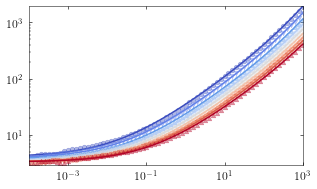

In [31]:
res_fit_dict_TC={}
fig, ax, color, amerker = create_plot()
AIC_list=[]
x = np.logspace(-4, 3, 30)
for c, dfh in df_temp.groupby('temperature', sort=False):
    col=next(color)
    ax.loglog(dfh.shear_rate, dfh.shear_stress, c=dict_colors[c], mfc=dict_colors[c], alpha=0.4, marker=next(marker), label=f'${c}$', linestyle='none')
    res_fit_dict_TC[c]=rheofit.models.TC_model.fit(dfh.shear_stress,x=dfh.shear_rate, weights=1/dfh.shear_stress)
    ax.plot(x, res_fit_dict_TC[c].eval(x=x), color=dict_colors[c], marker='', ls='-', lw=1.5)
    AIC_list.append(res_fit_dict_TC[c].aic)
res_table=pybroom.tidy(res_fit_dict_TC)
TC_fit_table=res_table.pivot(index='key',columns='name',values='value')
TC_fit_table['AIC']=AIC_list
TC_fit_table_T=TC_fit_table.round(3)
TC_fit_table_T
plt.show();

In [32]:
TC_fit_table

name,TC_eta_bg,TC_gammadot_crit,TC_ystress,AIC
key,,,,
10,0.961911,0.018488,4.075049,-433.856607
15,0.706046,0.027217,3.887585,-497.668771
20,0.518591,0.036651,3.716681,-524.093755
25,0.390594,0.046400,3.533892,-474.312927
30,0.301737,0.059814,3.416772,-487.271049
35,0.237345,0.073499,3.286520,-476.615178
40,0.194764,0.093889,3.227567,-491.465352
45,0.161388,0.124064,3.352500,-458.031940
50,0.131882,0.147617,3.297516,-452.674637


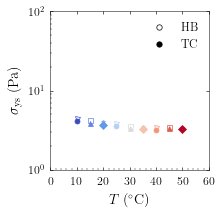

In [33]:
fig, ax, color, marker = create_plot(two_sided=True)

for T in TC_fit_table.index:
    c = next(color)
    ax.plot(T, TC_fit_table.loc[T, 'TC_ystress'], c=dict_colors[T], mfc=dict_colors[T], marker=next(marker), ms=5)
    ax.plot(T, HB_fit_table.loc[T, 'HB_ystress'], c=dict_colors[T], mfc='None', marker=next(marker), ms=5)

handles = [mpl.lines.Line2D([], [], c='k', label=r'$\mathrm{HB}$'),
           mpl.lines.Line2D([], [], c='k', mfc='k', label=r'$\mathrm{TC}$')]


ax.legend(handles=handles, loc='upper right')

ax.set(xlim=(0, 60), ylim=(1, 100), 
       xticks=[0, 10, 20, 30, 40, 50, 60],
       yscale='log',
       xlabel='$T~(^\circ \mathrm{C})$',
       ylabel='$\sigma_\mathrm{ys}~\mathrm{(Pa)}$'
      )

fig.savefig('./figures_marco/concentration_sweep_parameters/ys_T.svg')

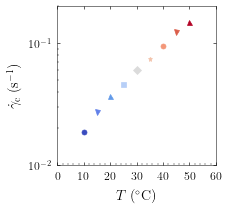

In [34]:
fig, ax, color, marker = create_plot(two_sided=True)

for T in TC_fit_table.index:
    c = next(color)
    ax.plot(T, TC_fit_table.loc[T, 'TC_gammadot_crit'], c=dict_colors[T], mfc=dict_colors[T], marker=next(marker), ms=5)
    


ax.set(xlim=(0, 60), ylim=(0.01, 0.2), 
       xticks=[0, 10, 20, 30, 40, 50, 60],
       yscale='log',
       xlabel='$T~(^\circ \mathrm{C})$',
       ylabel='$\dot{\gamma}_\mathrm{c}~\mathrm{(s^{-1})}$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/gammadotcrit_T.svg')

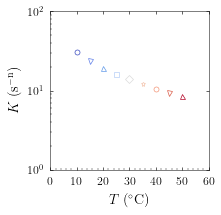

In [35]:
fig, ax, color, marker = create_plot(two_sided=True)

for T in TC_fit_table.index:
    c = next(color)
    ax.plot(T, HB_fit_table.loc[T, 'HB_K'], c=dict_colors[T], mfc='none', marker=next(marker), ms=5)
    


ax.set(xlim=(0, 60), ylim=(1, 100), 
       xticks=[0, 10, 20, 30, 40, 50, 60],
       yscale='log',
       xlabel='$T~(^\circ \mathrm{C})$',
       ylabel='$K~\mathrm{(s^{-n})}$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/k_T.svg')

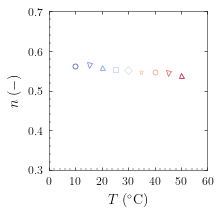

In [36]:
fig, ax, color, marker = create_plot(two_sided=True)

for T in TC_fit_table.index:
    c = next(color)
    ax.plot(T, HB_fit_table.loc[T, 'HB_n'], c=dict_colors[T], mfc='none', marker=next(marker), ms=5)
    


ax.set(xlim=(0, 60), ylim=(0.3, 0.7), 
       xticks=[0, 10, 20, 30, 40, 50, 60],
       yscale='linear',
       xlabel='$T~(^\circ \mathrm{C})$',
       ylabel='$n~(-)$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/n_T.svg')

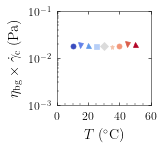

In [37]:
fig, ax, color, marker = create_plot(figsize=(2.5, 2.5))

for T in TC_fit_table.index:
    c = next(color)
    ax.plot(T, TC_fit_table.loc[T, 'TC_eta_bg']* TC_fit_table.loc[T, 'TC_gammadot_crit'], c=dict_colors[T], mfc=dict_colors[T], marker=next(marker), ms=5)
    


ax.set(xlim=(0, 60), ylim=(1e-3, 0.1), 
       xticks=[0, 20, 40, 60],
       yscale='log',
      xlabel='$T~(^\circ \mathrm{C})$',
       ylabel=r'$\eta_\mathrm{bg} \times \dot{\gamma}_\mathrm{c}~\mathrm{(Pa)}$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/ys_gammadotcrit_T.svg')

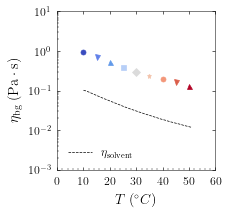

In [38]:
fig, ax, color, marker = create_plot(two_sided=True)

for T in TC_fit_table.index:
    c = next(color)
    ax.plot(T, TC_fit_table.loc[T, 'TC_eta_bg'], c=dict_colors[T], mfc=dict_colors[T], marker=next(marker), ms=5)

ax.plot(visc_round.iloc[:42], ls='--', color='black', marker='', label='$\eta_\mathrm{solvent}$')
    
ax.legend(loc='lower left')

ax.set(ylim=(0.001, 10), 
       yscale='log',
       xlim=(0, 60), 
       xticks=[0, 10, 20, 30, 40, 50, 60],
       xlabel='$T~(^\circ C)$', 
       ylabel='$\eta_\mathrm{bg}~(\mathrm{Pa \cdot s})$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/visc_T.svg')

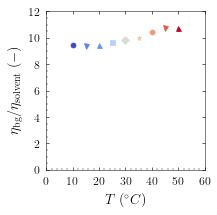

In [41]:
fig, ax, color, marker = create_plot(two_sided=True)

for T in TC_fit_table.index:
    c = next(color)
    ax.plot(T, TC_fit_table.loc[T, 'TC_eta_bg'] / visc_round[T] , c=dict_colors[T], mfc=dict_colors[T], marker=next(marker), ms=5)

#ax.plot(visc_round.iloc[:42], ls='--', color='black', marker='', label='$\eta_\mathrm{solvent}$')
    
#ax.legend(loc='lower left')

ax.set(ylim=(0, 12), 
       #yscale='log',
       xlim=(0, 60), 
       xticks=[0, 10, 20, 30, 40, 50, 60],
       xlabel='$T~(^\circ C)$', 
       ylabel='$\eta_\mathrm{bg} / \eta_\mathrm{solvent}~(-)$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/ratio_visc_T.svg')